# Stock-level datasets 

In [1]:
# hide
import logging

logging.getLogger("yfinance").setLevel(logging.CRITICAL)

In [2]:
import pandas as pd
import yfinance as yf
from skfin.plot import *
from tqdm.auto import tqdm

## Returns data 

### Scikit-learn returns

Main issue: very limited information on how the returns were constructed. 

In [3]:
from skfin.dataloaders.constants.mappings import symbol_dict
from skfin.datasets_ import load_sklearn_stock_returns

clip = lambda x: x.T.clip(
    lower=x.quantile(q=0.01, axis=0), upper=x.quantile(0.99, axis=0), axis=0
).T
rescale = lambda x: x.div(x.std())

In [4]:
ret = load_sklearn_stock_returns(cache_dir="data") / 100
ret_clip = ret.pipe(clip)

INFO:skfin.dataloaders.cache:Loading from cache : data/sklearn_returns.parquet


### Yahoo finance returns

Main issue: survival bias because the deslisted firms are no longer available in the past.

In [5]:
tickers = list(symbol_dict.keys())
start, end = ret.index[0].strftime("%Y-%m-%d"), ret.index[-1].strftime("%Y-%m-%d")

In [6]:
data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
data = data.dropna(how="all", axis=1)

In [7]:
tickers_ = data.columns.get_level_values(1).unique()
dividends = {}
for ticker in tickers_:
    stock = yf.Ticker(ticker)
    div = stock.dividends[start:end]
    if div.dtype == "O":
        div = div.str.replace(" USD", "").astype(float)
    dividends[ticker] = div

div = (
    pd.concat(dividends, axis=1)
    .pipe(lambda x: x.set_index(x.index.tz_localize(None)))
    .reindex_like(data["Close"])
    .fillna(0)
    .astype(float)
    .div(data["Close"])
)

## Survivingship bias 

In [8]:
cols = ["CAJ", "SNE", "UN", "NAV", "TOT", "RTN", "DELL", "YHOO", "CVC"]
{c: symbol_dict[c] for c in cols}

{'CAJ': 'Canon',
 'SNE': 'Sony',
 'UN': 'Unilever',
 'NAV': 'Navistar',
 'TOT': 'Total',
 'RTN': 'Raytheon',
 'DELL': 'Dell',
 'YHOO': 'Yahoo',
 'CVC': 'Cablevision'}

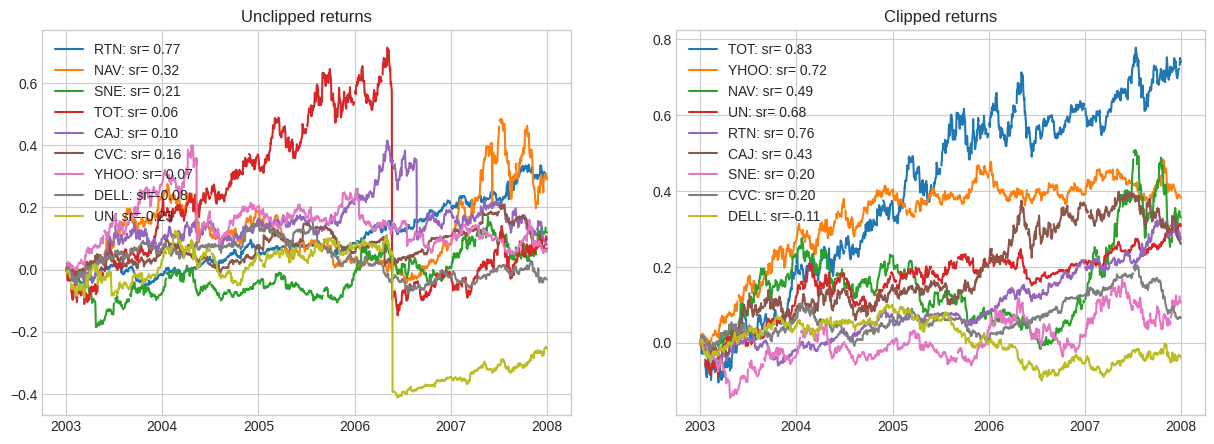

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
line(ret[cols], cumsum=True, ax=ax[0], title="Unclipped returns", loc="best")
line(ret_clip[cols], cumsum=True, ax=ax[1], title="Clipped returns", loc="best")

### Dirty data and jumps 

Total returns are defined as: 

$$ total\_returns_t = \frac{price_t + dividend_t - price_{t-1}}{price_{t-1}}.$$ 

Adjustments are necessary when there are stock splits (or reverse splits) that alter the number of shares outstanding and the nominal price per share.

In [10]:
data.columns.get_level_values(0).unique()

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [11]:
pret = data["Close"].pct_change().dropna(how="all", axis=1)
tret = pret.add(div)

In [12]:
rets = {
    "price returns": pret,
    "total returns": tret,
}

In [13]:
axis = 0
pd.DataFrame({k: v.corrwith(ret, axis=axis) for k, v in rets.items()}).mean()

price returns    0.815361
total returns    0.805144
dtype: float64

In [14]:
axis = 0
pd.DataFrame({k: v.corrwith(ret_clip, axis=axis) for k, v in rets.items()}).mean()

price returns    0.943665
total returns    0.931119
dtype: float64

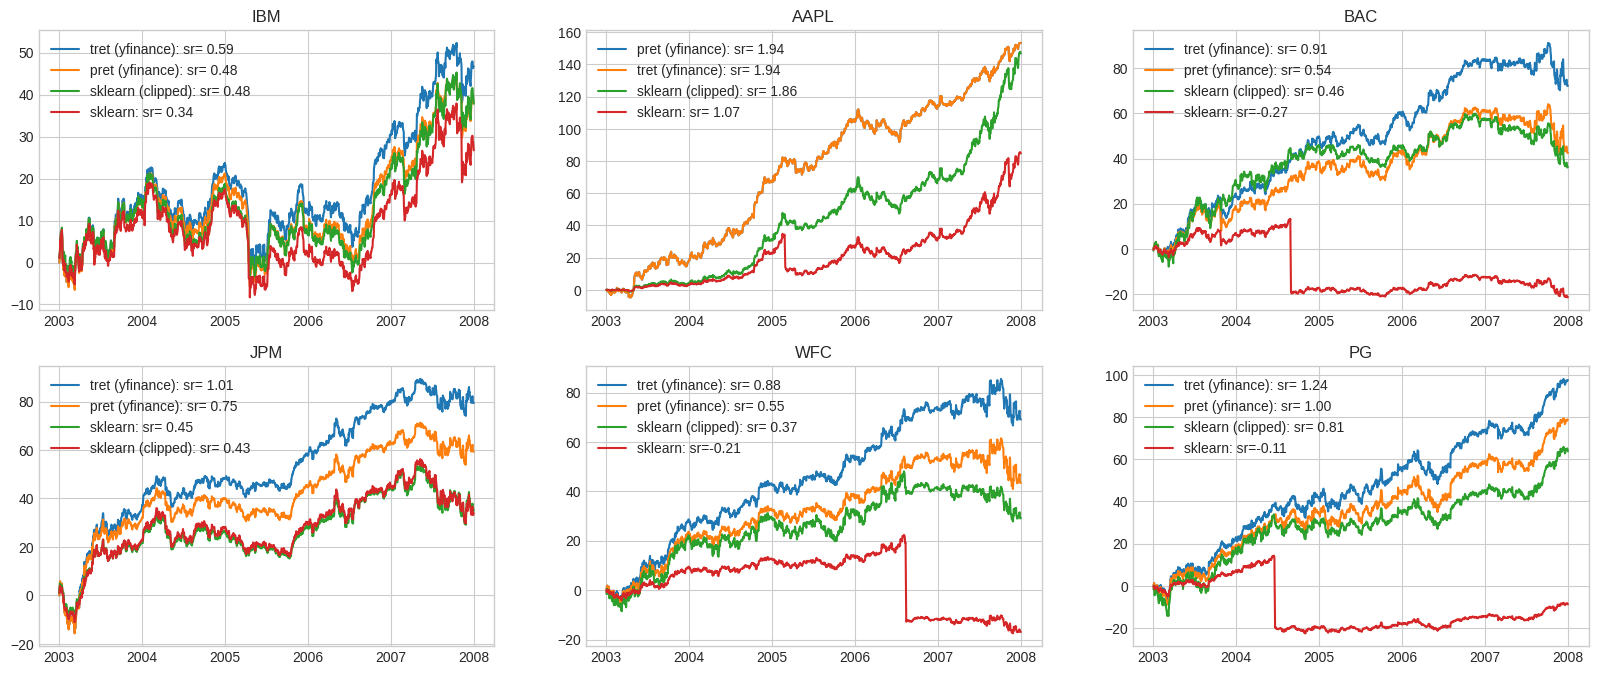

In [15]:
cols = ["IBM", "AAPL", "BAC", "JPM", "WFC", "PG"]
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
axs = axs.ravel()
for i, c in enumerate(cols):
    line(
        pd.concat(
            {
                "pret (yfinance)": pret[c],
                "tret (yfinance)": tret[c],
                "sklearn": ret[c],
                "sklearn (clipped)": ret_clip[c],
            },
            axis=1,
        )
        .fillna(0)
        .pipe(rescale),
        cumsum=True,
        title=c,
        ax=axs[i],
        loc="best",
    )

## Matching to other datasets 

Matching company names is often a time-consuming task: below we use the package `rapidfuzz` to check the candidate matches. 

In [16]:
from skfin.datasets_ import load_10X_summaries
from skfin.dataloaders.constants.mappings import mapping_10X

df = load_10X_summaries()

INFO:skfin.dataloaders.cache:Loading from cache : data/Loughran-McDonald_10X_Summaries_1993-2021.csv


In [17]:
df

,CIK,FILING_DATE,ACC_NUM,CPR,FORM_TYPE,CoName,SIC,FFInd,N_Words,N_Unique_Words,...,N_WeakModal,N_Constraining,N_Negation,GrossFileSize,NetFileSize,NonTextDocTypeChars,HTMLChars,XBRLChars,XMLChars,N_Exhibits
date,,,,,,,,,,,,,,,,,,,,,
1993-08-13,60512,19930813,0000060512-94-000005,19930630,10-Q,LOUISIANA LAND & EXPLORATION CO,1311,30,4068,770,...,6,8,1,63255,43072,0,464,0,0,0
1993-08-13,66740,19930813,0000066740-94-000015,19930630,10-Q,MINNESOTA MINING & MANUFACTURING CO,2670,38,4389,844,...,7,8,3,57283,37946,0,392,0,0,3
1993-10-07,60512,19931007,0000060512-94-000006,19921231,10-K-A,LOUISIANA LAND & EXPLORATION CO,1311,30,8719,1239,...,15,32,5,114136,86058,0,944,0,0,0
1993-11-10,60512,19931110,0000060512-94-000007,19930930,10-Q,LOUISIANA LAND & EXPLORATION CO,1311,30,4938,812,...,4,5,1,72062,50742,0,505,0,0,0
1993-11-12,11860,19931112,0000011860-94-000005,19930930,10-Q,BETHLEHEM STEEL CORP /DE/,3312,19,3823,898,...,5,32,2,40392,32088,0,201,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,1317839,20211230,0001477932-21-009563,20210930,10-Q,Umatrin Holding Ltd,7389,34,4795,898,...,11,19,7,4180291,38642,641880,1084579,936212,1361281,7
2021-12-30,1796160,20211230,0001096906-21-003094,20210930,10-Q,QMIS TBS Capital Group Corp.,6211,47,8028,1083,...,24,36,6,3537544,62494,516984,1121439,797163,949861,9
2021-12-30,1867956,20211230,0001683168-21-006658,20211130,10-Q,Linktory Inc.,7370,34,3673,706,...,9,28,4,1320557,28483,319756,226958,315552,406289,8


In [18]:
v = mapping_10X["CVC"]
print(v)
df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])].loc[
    ret.index[0] : ret.index[-1]
].loc["2006"].iloc[:, :10]

CABLEVISION SYSTEMS CORP /NY


,CIK,FILING_DATE,ACC_NUM,CPR,FORM_TYPE,CoName,SIC,FFInd,N_Words,N_Unique_Words
date,,,,,,,,,,
2006-05-10,1053112,20060510,0001104659-06-032803,20060331,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,38566,2327
2006-05-10,784681,20060510,0001104659-06-032803,20060331,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,38566,2327
2006-09-21,1053112,20060921,0001104659-06-062197,20051231,10-K-A,CABLEVISION SYSTEMS CORP /NY,4841,32,92495,2946
2006-09-21,784681,20060921,0001104659-06-062197,20051231,10-K-A,CABLEVISION SYSTEMS CORP /NY,4841,32,92495,2946
2006-09-21,1053112,20060921,0001104659-06-062201,20060331,10-Q-A,CABLEVISION SYSTEMS CORP /NY,4841,32,35794,1966
2006-09-21,784681,20060921,0001104659-06-062201,20060331,10-Q-A,CABLEVISION SYSTEMS CORP /NY,4841,32,35794,1966
2006-11-08,1053112,20061108,0001104659-06-072875,20060930,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,45265,2148
2006-11-08,784681,20061108,0001104659-06-072875,20060930,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,45265,2148


In [19]:
CoName = list(
    df.assign(CoName=lambda x: x.CoName.str.upper())
    .groupby(["date", "CoName"])["FILING_DATE"]
    .count()
    .loc[ret.index[0] : ret.index[-1]]
    .groupby(level=1)
    .count()
    .index
)

from rapidfuzz import fuzz

pd.Series({c: fuzz.token_set_ratio("CABLEVISION", c) for c in CoName}).sort_values(
    ascending=False
).head(5)

CABLEVISION SYSTEMS CORP /NY    100.000000
PARKERVISION INC                 66.666667
CAGLES INC                       66.666667
ABLEST INC                       66.666667
LATIN TELEVISION  INC            64.516129
dtype: float64